In [424]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode_paper/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle
import warnings
from itertools import product
warnings.filterwarnings("ignore", message="y_pred contains classes not")

from IPython.display import display
import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes('deep')
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
plt.style.use('seaborn-v0_8-muted')
from sklearn.metrics import mean_absolute_error, mean_squared_error, balanced_accuracy_score

from braindecode.datasets.tuh import TUHAbnormal
from braindecode.preprocessing import create_fixed_length_windows

from decode_tueg import (
    DataScaler, TargetScaler, trial_age_mae, Augmenter, ChannelsSymmetryFB,
    get_datasets, test_name, create_windows, create_final_scores,
    plot_age_gap_hist, accuracy_perumtations, 
    age_gap_diff_permutations,
    plot_learning_curves, save_fig, read_result,
    load_exp, predict_ds, plot_heatmaps, plot_age_gap_hist_and_permutation_test,
    plot_age_gap_hist_with_thresh_and_permutation_test, deconfound,
    fit_deconfound_model, 
)

Thu Mar 28 12:52:56 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:B1:00.0 Off |                  N/A |
| 33%   34C    P0    37W / 250W |      0MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
save_figures = False

In [4]:
# TODO: 
# improve handling of cv / final eval in this notebook
# rename eval back to valid? makes things easier
# always compute mean over folds and afterwards over seeds?

In [5]:
#work_dir = '/home/jovyan/workspace-tueg/'
work_dir = '/home/jovyan/'
#work_dir = '/home/lukas/Code/brain_age/'

In [6]:
base_dir = os.path.join(work_dir, 'experiments')
# exp = '2022-10-07T14:07:06.646966'  # deep all ages, lr=0.005
# exp = '2022-10-06T09:37:01.278443'  # deep all ages, lr=0.01
# exp = '2022-10-05T14:36:25.074269'  # shallow all ages
# exp = '2022-09-28T10:25:47.571160'  # shallow ages >= 18
# exp = '2022-09-28T22:24:18.385389'  # TCN all ages, still with 'valid_rest'
# exp = '2022-10-06T20:10:52.312837'  # TCN all ages, 5 seeds
# exp = '2022-09-29T15:49:14.606557'  # TCN ages >= 18
# exp = '2022-10-08T08:04:26.625918'  # TCN matched patho and non-patho dist in all ages
# exp = '2022-10-09T09:55:45.307781'  # TCN uniformly matched patho and non-patho age dist in >=18 and <=86
# exp = '2022-10-09T12:02:46.142332'  # TCN all ages, sign augmentation isntead of dropout
# exp = '2022-10-12T08:10:43.911642'  # TCN all ages age_clf

#exp = '2022-10-12T11:25:00.490417'  # TCN exluding recs with age divergence, cv
#exp = '2022-10-17T16:24:10.124445'  # TCN exluding recs with age divergence, final eval

#exp = '2023-02-07T06:28:03.373666' # TCN exluding recs with age divergence, subject-wise cv
#exp = '2023-02-09T09:34:21.685021' # TCN exluding recs with age divergence, subject-wise fe 


#exp = '2023-02-10T23:14:51.938016'  # mixed patho and non-patho data
#exp = '2023-02-11T09:11:11.990975'  # subset non-patho, match patho and non-patho dists
#exp = '2023-02-11T09:11:23.883557'  # subset non-patho, uniform patho and non-patho dists

exp = '2023-02-15T18:59:11.767923'  # cv, l1loss
exp = '2023-02-15T18:43:26.819382'  # fe, l1loss
#exp = '2023-05-04T08:38:44.048946'  # cv, l2loss
#exp = '2023-05-08T09:22:38.974401'  # fe, l2loss  # currently re-running with longitudinals
#exp = '2023-05-09T09:15:59.256046'  # fe, l2loss  # longitudinal crashed

#exp = '2023-02-22T12:51:02.928667'


exp_dir = os.path.join(base_dir, exp)

In [7]:
configs = read_result(exp_dir, 'config')

In [8]:
assert len(configs) == 5

In [9]:
configs.iloc[0]

augment                                                                dropout
batch_size                                                                 128
data_path                    /home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...
date                                                2023-02-15T18:43:26.819382
debug                                                                        1
fast_mode                                                                    1
final_eval                                                                   1
intuitive_training_scores                                                    1
loss                                                                       mae
max_age                                                                     -1
min_age                                                                     -1
model_name                                                                 tcn
n_epochs                                            

In [10]:
assert configs['final_eval'].nunique() == 1

In [11]:
configs[['model_name', 'target_name', 'valid_set_i', 'seed', 'final_eval']]

,model_name,target_name,valid_set_i,seed,final_eval
0,tcn,age,0,20230214,1
0,tcn,age,0,20230215,1
0,tcn,age,0,20230216,1
0,tcn,age,0,20230217,1
0,tcn,age,0,20230218,1


In [12]:
scores = read_result(exp_dir, 'score')

In [13]:
def average_scores(scores):
    scores_ = {}
    for score in scores.index.unique():
        for subset in scores.columns:
            if subset not in scores_:
                scores_[subset] = {}
            scores_[subset].update({score: scores.loc[score, subset].mean()})
    return pd.DataFrame(scores_).drop(['seed', 'valid_set_i'], axis=1)

In [14]:
average_scores(scores)

,train,eval,eval_not_normal,transition,non_pathological,pathological,transition_long,non_pathological_long,pathological_long,transition_long_clean_age,non_pathological_long_clean_age,pathological_long_clean_age,lnp,lp,lnpp,lpnp,nlnp,nlp,nlnpp,nlpnp
mae,2.676739,6.517127,13.415539,11.770793,1.337067e+01,16.250088,11.697070,1.202639e+01,15.792732,12.120994,11.815610,15.638920,10.047124,15.254722,12.192501,11.074950,15.415788,15.062218,15.681809,15.807203
mape,0.065842,0.166104,0.232763,0.407534,2.108755e+06,587487.061264,0.407996,2.386170e+06,586644.279400,0.376190,0.559343,0.377315,0.264614,0.333503,0.340080,0.298033,0.582752,0.488811,0.558147,0.565154
mdae,1.742511,5.434862,11.378739,9.664617,9.604606e+00,13.560675,9.404413,8.497187e+00,13.093110,9.613568,9.237580,12.994081,8.138520,12.749054,9.489480,9.735177,11.782431,11.640397,12.346581,12.637010
mdape,0.042046,0.136944,0.201271,0.206327,2.239139e-01,0.252980,0.201404,2.034687e-01,0.244721,0.206254,0.215884,0.244187,0.193608,0.238624,0.197763,0.217654,0.233398,0.234721,0.244347,0.250891
r2,0.938632,0.729647,0.091834,0.301654,1.705781e-01,-0.077597,0.309442,2.445779e-01,-0.066213,0.230802,0.159408,-0.147724,0.325734,-0.141933,0.173828,0.378128,-0.000566,0.053113,-0.065933,-0.058529


In [15]:
histories = read_result(exp_dir, 'history')

In [16]:
loss = configs['loss'].unique()
assert len(loss) == 1
loss = loss[0]
if loss == 'mae':
    loss_label = 'L1 Loss' 
elif loss == 'mse':
    loss_label = 'L2 Loss'
else:
    raise NotImplementedError

In [17]:
fe = (configs['final_eval'] == '1').all()

In [18]:
cv_or_fe = 'fe' if fe else 'cv'

In [19]:
fe, cv_or_fe

(True, 'fe')

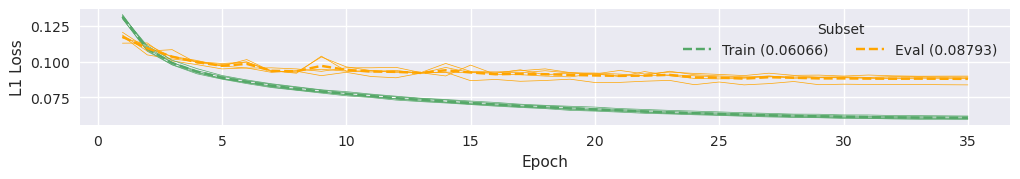

In [20]:
if fe:
    histories['eval_run_i'] = (histories['epoch'] == 1).cumsum() - 1
    ax = plot_learning_curves([g2 for n2, g2 in histories.groupby('eval_run_i')], loss_label, 'Eval')
    #ax.get_figure().savefig(os.path.join(work_dir, 'final_eval_curves.png'), dpi=300, bbox_inches='tight')
    if save_figures:
        save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_curves.png')
else:
    for n1, g1 in histories.groupby('seed'):
        ax = plot_learning_curves([g2 for n2, g2 in g1.groupby('valid_set_i')], loss_label)
        # ax.set_title(f'Deep4, lr=0.005')
        # ax.set_title(f'Seed: {n1}')
        #ax.get_figure().savefig(os.path.join(work_dir, f'cv_curves_{n1}.png'), dpi=300, bbox_inches='tight')
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_curves_{n1}')

In [21]:
def prepare_preds(g1, sex, min_age, max_age, fe):
    g1 = g1[g1.gender==sex] if sex is not None else g1
    max_age = g1.age.max() if max_age is None else max_age
    min_age = g1.age.min() if min_age is None else min_age
    g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
    # if fe, average over different seeds; if cv, basically don't average
    grouper = ['subset', 'index'] if fe else ['subset', 'subject', 'session', 'segment', 'seed']
    # after averaging, seed variable does not make sense anymore, so drop it
    g1 = g1.reset_index().groupby(grouper, as_index=False).mean(numeric_only=True)#.drop(['seed'], axis=1)
    g1 = g1.groupby(['subset', 'pathological', 'subject'], as_index=False).mean(numeric_only=True)
    return g1


def add_deconfounded_predictions(g1, coefs):
    if coefs is None:
        coefs = fit_deconfound_model(
            g1[g1.pathological == False].y_true, 
            g1[g1.pathological == False].y_pred, 
        )
    g1['y_pred_confounded'] = g1.y_pred
    for kind, coef in coefs.items():
        #g1[f'y_pred_deconfounded_{kind}'] = g1.y_pred - [coefs_to_func(coef, y) for y in g1.y_true]  # y
        g1[f'y_pred_deconfounded_{kind}'] = g1.y_pred - [coefs_to_func(coef, y) for y in g1.y_pred]
    return g1, coefs


# from list of coeffs generate a string representing the function formula
def coefs_to_func_str(coefs):
    s = ''.join([f' + {coef:.1e}'+'x'*i if coef >= 0 else f'{coef:.1e}'+'x'*i for i, coef in enumerate(coefs[::-1])][::-1])
    if s.startswith('+'):
        s = s[2:]
    return 'f(x) = ' + s


# from list of coeffs compute the result of the represented function
def coefs_to_func(coefs, x):
    # coefs from high to low order
    return sum([coef*x**i for i, coef in enumerate(coefs[::-1])][::-1])


# plot bias of model that is being fit: ytrue to ypred-ytrue
def plot_true_age_vs_gap(y_true, y_pred, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.scatter(y_true, y_pred-y_true, facecolor='b', edgecolor='k', alpha=.5)
    ax.plot([0,100],[0,0], c='k', linewidth=1)
    ax.set_xlabel('Chronological Age [years]')
    ax.set_ylabel('Brain Age Gap\n[years]')
    ax.legend();
    ylim = np.max(np.abs(ax.get_ylim()))
    ax.set_ylim(-ylim, ylim)
    return ax


def plot_bias_model(coeffs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    for (kind, coefs), style in zip(coeffs.items(), ['-', ':']):
        ax.plot(
            [coefs_to_func(coefs, p) for p in np.arange(100)], 
            label=coefs_to_func_str(coefs), linewidth=2,
            linestyle=style, c='cyan',
        )
    ax.legend(loc='lower left')
    return ax


def plot_model_bias(y_true, y_pred, coeffs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax = plot_true_age_vs_gap(preds.y_true, preds.y_pred, ax=ax)
    ax = plot_bias_model(coeffs, ax)
    return ax

In [22]:
preds = read_result(exp_dir, 'preds')
preds.shape

(1215, 20)

In [23]:
age_limits = [(None, None)]# [(None, 30), (30, 60), (60, None)]  #[(None, 30), (30, 60), (60, None)]#
sexes = [None]#['F', 'M'] #[None]#

In [24]:
preds = prepare_preds(preds, sex=None, min_age=None, max_age=None, fe=fe)
preds.shape

(219, 17)

In [25]:
def accs_for_patho_from_thresh(series, pathological):
    assert len(series) == len(pathological)
    accs = []
    for i in range(len(series)):
        acc = balanced_accuracy_score(pathological, i*[0]+(len(series)-i)*[1])
        accs.append(acc*100)
    return accs


def plot_accs_for_patho_from_thresh(dataframe, accs, ax=None):
    df = dataframe.copy()
    df.pathological = df.pathological == 1
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 1.5))
    #ax2 = ax.twinx()
    #ax2 = sns.histplot(data=tmp, x='y_true', hue='pathological', ax=ax2, binwidth=1, palette={0: 'b', 1: 'r'})
    ax.plot(df.y_true, accs, c='k')
    #ax.plot(data=df, x='y_true', y=accs, c='k', ax=ax, errorbar=None)#, hue='pathological', palette={0: 'b', 1: 'r'}, alpha=.5)
    #ax.plot([0, 100], [50, 50], c='k', linestyle='--')
    #ax.axvline(tmp.y_true.iloc[np.array(accs).argmax()], c='cyan', linewidth=1)
    ax.set_ylabel('Balanced Accuracy\n[%]')
    return ax

In [26]:
from decode_tueg import plot_violin_new, accuracy_perumtations, get_hist_perm_test_grid

In [28]:
n_repetitions = 1000
save_figures = False

acc based on cv age thresh (48.25) 66.54%
acc based on fe age thresh (62.00) 67.13%
p=1.00E-03


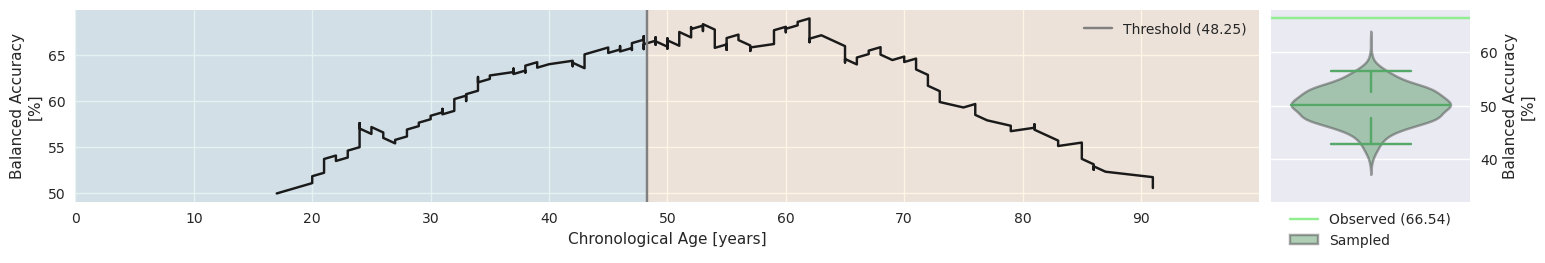

In [29]:
ax0, ax1 = get_hist_perm_test_grid()
accs = accs_for_patho_from_thresh(
    preds.sort_values('y_true').y_true,
    preds.sort_values('y_true').pathological,
)
ax = plot_accs_for_patho_from_thresh(
    preds.sort_values('y_true'),
    accs,
    ax0,
)
ax.set_xlim([0, 100])
if not fe:
    thresh = preds.sort_values('y_true').y_true.iloc[np.argmax(accs)]
    #thresh = 48.25000096857548
    #print(f'cv age thresh {thresh:.2f}')
    acc = 100*balanced_accuracy_score(preds.pathological, preds.y_true > thresh)
    print(f'acc based on cv age thresh ({thresh:.2f}) {acc:.2f}%')    
else:
    thresh = 48.25000096857548
    acc = 100*balanced_accuracy_score(preds.pathological, preds.y_true > thresh)
    print(f'acc based on cv age thresh ({thresh:.2f}) {acc:.2f}%')    
    optimal_thresh = preds.sort_values('y_true').y_true.iloc[np.argmax(accs)]
    print(f'acc based on fe age thresh ({optimal_thresh:.2f}) {(100*balanced_accuracy_score(preds.pathological, preds.y_true > optimal_thresh)):.2f}%')    
    #print(f'acc based on cv age thresh {(100*balanced_accuracy_score(preds.pathological, preds.y_true > thresh)):.2f}%')
ax.axvline(thresh, c='grey', label=f'Threshold ({thresh:.2f})')
ax.set_xlabel('Chronological Age [years]')

ax.axvspan(0, thresh, facecolor='teal', alpha=.1)
ax.axvspan(thresh, 100, facecolor='orange', alpha=.1)

observed, sampled = accuracy_perumtations(
    preds,
    n_repetitions=n_repetitions,
    indicator='age',
)
plot_violin_new(
    acc,
    sampled,
    50,
    ax1,
)
ax1.set_ylabel('Balanced Accuracy\n[%]')

ticks = np.linspace(0,100,11,dtype=int)[:-1]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.legend()

#ax.axvline(preds[preds.pathological==1].y_true.mean(), c='magenta')
#ax.axvline(preds[preds.pathological==0].y_true.mean(), c='teal')
#ax.legend(title='Pathological')
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_age_thresh')

In [30]:
preds['gap'] = preds.y_pred - preds.y_true
accs = accs_for_patho_from_thresh(
    preds.sort_values('gap').gap,
    preds.sort_values('gap').pathological,
)

In [31]:
# TODO: fix
ax = plot_accs_for_patho_from_thresh(
    preds.sort_values('gap').gap,
    accs,
)
thresh = preds.sort_values('gap').gap.iloc[np.argmax(np.abs([100-a for a in accs]))]
ax.axvline(thresh, c='grey')
ax.set_xlabel('Decoded Age – Chronological Age [years]')

AttributeError: 'Series' object has no attribute 'pathological'

In [32]:
# exp = '2023-02-15T18:59:11.767923'  # cv, l1loss
# exp = '2023-02-15T18:43:26.819382'  # fe, l1loss
cv_exp_dir = '/home/jovyan/experiments/2023-02-15T18:59:11.767923'
cv_seed = '20230214'

In [33]:
if not fe:
    assert configs.seed.nunique() == 1
    cv_seed = configs.seed.unique()[0]
    cv_exp_dir = exp_dir
cv_dir = os.path.join(cv_exp_dir, cv_seed)

In [34]:
# if cv_dir is None
fn = 'bias_models.json'
if not fe:
    preds, coeffs = add_deconfounded_predictions(preds, coefs=None)
    p = os.path.join(cv_dir, fn)
    print(f"duming model coefficients to {p}")
    json.dump(coeffs, open(p, 'w'))
else:
    p = os.path.join(cv_dir, fn)
    print(f"loading model coefficients from {p}")
    coeffs = json.load(open(p, 'r'))
    preds, coeffs = add_deconfounded_predictions(preds, coefs=coeffs)
coeffs

loading model coefficients from /home/jovyan/experiments/2023-02-15T18:59:11.767923/20230214/bias_models.json


{'linear': [-0.36310181197536046, 15.374280445171014],
 'quadratic': [-0.004431773520303435, 0.05752921309654997, 6.582235069495847]}

In [35]:
def plot_biased_vs_corrected_gap_to_age_with_dists(y_true, y_pred, y_pred_deconfounded, coeffs, age_hist=True, binwidth=1):
    fig, ax_arr = plt.subplots(3, 2, figsize=(12,5), width_ratios=[.9, .1])
    fig.subplots_adjust(hspace=.1)
    fig.subplots_adjust(wspace=.025)

    if not age_hist:
        ax = ax_arr[0,1]
        ax.remove()

    ax = ax_arr[1,0]
    ax = plot_model_bias(
        y_true, 
        y_pred,
        coeffs,
        ax=ax,
    )
    ax.set_xlabel('')
    ax.set_xticklabels([])
    lims = ax.get_ylim()

    ax = ax_arr[1,1]
    sns.histplot(y=y_pred-y_true, ax=ax, binwidth=binwidth, kde=True)
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.yaxis.tick_right()
    #ax.set_ylim([0,100])
    ax.set_ylabel("")
    ax.set_ylim(lims)

    ax = ax_arr[2,0]
    ax = plot_true_age_vs_gap(y_true, y_pred_deconfounded, ax=ax)
    ax.set_ylabel('Corrected\nBrain Age Gap\n[years]');
    ticks = ax.get_xticks()
    lim = ax.get_xlim()
    lims = ax.get_ylim()

    ax = ax_arr[2,1]
    sns.histplot(y=y_pred_deconfounded-y_true, ax=ax, binwidth=binwidth, kde=True)
    ax.yaxis.tick_right()
    #ax.set_ylim([0,100])
    ax.set_ylabel("")
    ax.set_ylim(lims)

    if age_hist:
        ax = ax_arr[0,0]
        sns.histplot(y_true, ax=ax, binwidth=binwidth, kde=True)
        ax.set_xlabel('')
        ax.set_xticklabels([]);
        ax.set_xticks(ticks)
        ax.set_xlim(lim)
    else:
        ax = ax_arr[0,0]
        ax.remove()
    return ax_arr

In [36]:
def plot_biased_vs_corrected_gap_to_age(y_true, y_pred, y_pred_deconfounded, coeffs):
    fig, ax_arr = plt.subplots(2, 1, figsize=(12,4), sharex=True)
    fig.subplots_adjust(hspace=.1)
    ax = plot_model_bias(
        y_true, 
        y_pred,
        coeffs,
        ax=ax_arr[0],
    )
    ax.set_xlabel('')
    ax = plot_true_age_vs_gap(y_true, y_pred_deconfounded, ax=ax_arr[1])
    ax.set_ylabel('Corrected\nBrain Age Gap\n[years]');
    return ax

In [37]:
fit_deconfound_model(preds[preds.pathological==0].y_true, preds[preds.pathological==0].y_pred)

{'linear': (-0.3290777344963141, 13.598413676371154),
 'quadratic': (-0.0017585743367344745,
  -0.16745359881063412,
  10.335490810065528)}

In [38]:
detrend = 'quadratic'

In [39]:
save_figures=False

In [40]:
# hardcode function in nice
def coefs_to_func_str(_):
    return r'$f(x) = -4.43 * 10^{-3}x^{2}  + 5.75 * 10^{-2}x + 6.58$'

In [41]:
save_figures=False

In [42]:
split = False

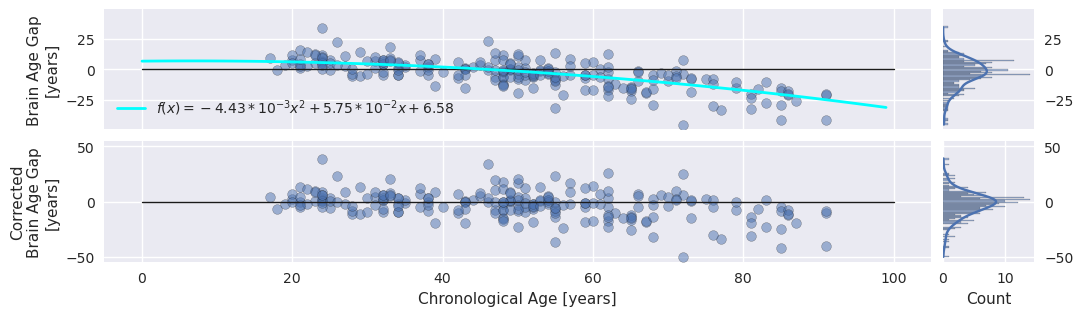

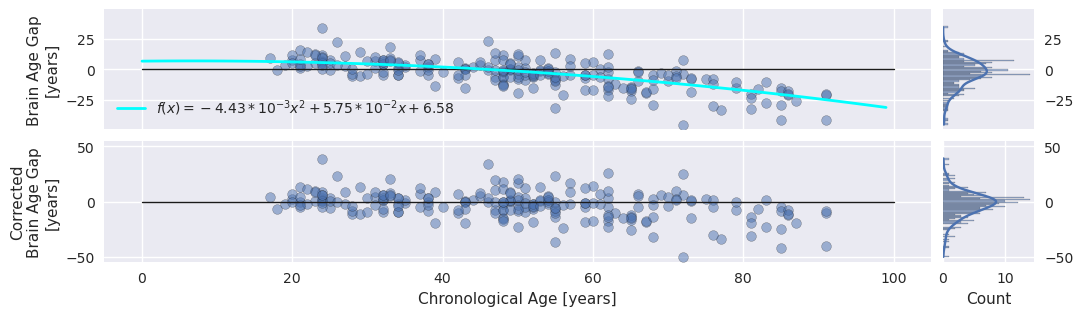

In [43]:
for i in [2, 1]:
    # plot_biased_vs_corrected_gap_to_age(preds.y_true, preds.y_pred, preds.y_pred_deconfounded_quadratic, coeffs)
    ax_arr = plot_biased_vs_corrected_gap_to_age_with_dists(
        preds.y_true, preds.y_pred, 
        preds[f'y_pred_deconfounded_{detrend}'], {detrend: coeffs[detrend]}, 
        age_hist=False)
    if save_figures:
        save_fig(ax_arr[-1,-1].get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_bias_model')

    if split:
        # only keep upper / lower part of plot
        ax_arr[i][0].remove()
        ax_arr[i][1].remove()
        ax_arr[1, 0].set_xlabel('Chronological Age [years]')
        if save_figures:
            save_fig(ax_arr[i, 0].get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_bias_model')


In [44]:
preds['y_pred'] = preds[f'y_pred_deconfounded_{detrend}']

In [45]:
from decode_tueg import find_threshs

In [46]:
fn = 'proxy_thresholds.json'
if not fe:
    (t_low, t_high) = find_threshs(preds)
    threshs = {'t_low': t_low, 't_high': t_high}
    p = os.path.join(cv_dir, fn)
    print(f"duming thresholds to {p}")
    json.dump(threshs, open(p, 'w'))
else:
    p = os.path.join(cv_dir, fn)
    print(f"loading thresholds from {p}")
    threshs = json.load(open(p, 'r'))
    t_low = threshs['t_low']
    t_high = threshs['t_high']  
t_low, t_high

loading thresholds from /home/jovyan/experiments/2023-02-15T18:59:11.767923/20230214/proxy_thresholds.json


(-9.219088895674346, 8.589625318405407)

In [47]:
bin_width = 2
n_repetitions = 100

In [48]:
if n_repetitions != 100000:
    print("WARNING! Wrong number of reps!")

WARNING! Wrong number of reps!


In [49]:
from decode_tueg import plot_permutation_test_and_age_gap_hist_with_thresh_and_permutation_test

In [50]:
from sklearn.metrics import r2_score, auc, roc_auc_score

In [51]:
def get_scores(preds):
    for pathological in [0, 1]:
        for deconfound in ['y_pred_confounded', 'y_pred_deconfounded_linear', 'y_pred_deconfounded_quadratic']:
            mae = mean_absolute_error(
                preds[preds.pathological==pathological].y_true,
                preds[preds.pathological==pathological][deconfound],
            )
            print(pathological, deconfound, 'mae', mae)
            r2 = r2_score(
                preds[preds.pathological==pathological].y_true,
                preds[preds.pathological==pathological][deconfound],
            )
            print(pathological, deconfound, 'r2', r2)
            print()

In [52]:
get_scores(preds)

0 y_pred_confounded mae 6.475429911260951
0 y_pred_confounded r2 0.7360309849351269

0 y_pred_deconfounded_linear mae 6.715772451107209
0 y_pred_deconfounded_linear r2 0.7064184678774831

0 y_pred_deconfounded_quadratic mae 6.60445472036638
0 y_pred_deconfounded_quadratic r2 0.7096574944386915

1 y_pred_confounded mae 13.307039500124315
1 y_pred_confounded r2 0.11324894066455349

1 y_pred_deconfounded_linear mae 12.614352418126181
1 y_pred_deconfounded_linear r2 0.11928884404284867

1 y_pred_deconfounded_quadratic mae 12.820447560321453
1 y_pred_deconfounded_quadratic r2 0.08936785812430659



In [53]:
n_repetitions = 100
save_figures = False

p=1.00E-02
p=1.00E-02


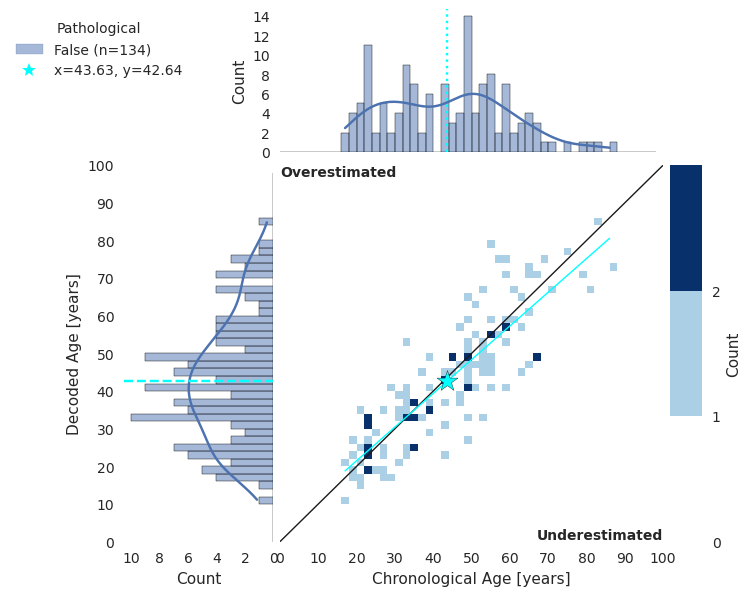

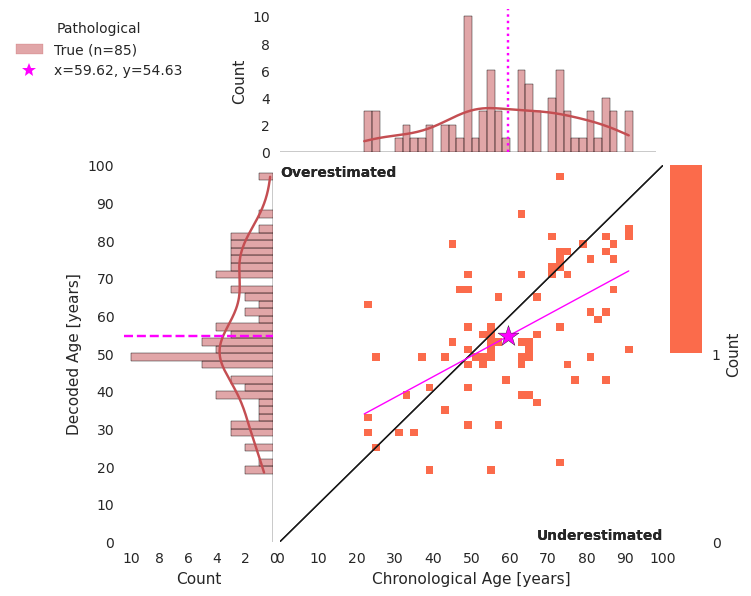

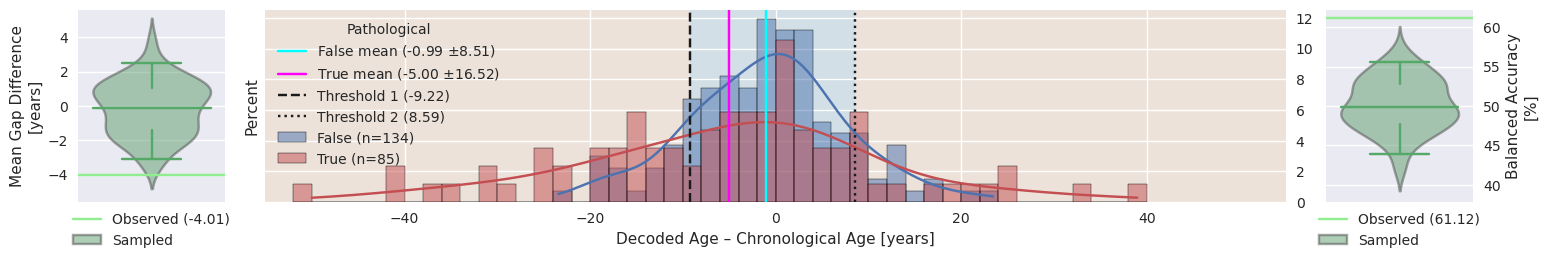

In [54]:
#preds['y_pred'] = preds[f'y_pred_deconfounded_{detrend}'] if not fe else preds['y_pred_confounded']
#preds['y_pred'] = preds[f'y_pred_confounded']
ax = plot_heatmaps(preds[preds.pathological==0], bin_width)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_np_age_heatmap')
ax = plot_heatmaps(preds[preds.pathological==1], bin_width)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_p_age_heatmap')
"""
# np and p together
ax = plot_heatmaps(preds, bin_width)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_age_heatmap')
"""
"""ax = plot_age_gap_hist_and_permutation_test(preds, bin_width, n_repetitions)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_age_gap_histogram')
ax = plot_age_gap_hist_with_thresh_and_permutation_test(
    preds, t_low, t_high, bin_width, n_repetitions,
)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_age_gap_proxy')
"""
ax = plot_permutation_test_and_age_gap_hist_with_thresh_and_permutation_test(
    preds, t_low, t_high, bin_width, n_repetitions,
)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_age_gap_hist_and_proxy')


In [55]:
get_scores(preds)

0 y_pred_confounded mae 6.475429911260951
0 y_pred_confounded r2 0.7360309849351269

0 y_pred_deconfounded_linear mae 6.715772451107209
0 y_pred_deconfounded_linear r2 0.7064184678774831

0 y_pred_deconfounded_quadratic mae 6.60445472036638
0 y_pred_deconfounded_quadratic r2 0.7096574944386915

1 y_pred_confounded mae 13.307039500124315
1 y_pred_confounded r2 0.11324894066455349

1 y_pred_deconfounded_linear mae 12.614352418126181
1 y_pred_deconfounded_linear r2 0.11928884404284867

1 y_pred_deconfounded_quadratic mae 12.820447560321453
1 y_pred_deconfounded_quadratic r2 0.08936785812430659



In [56]:
from scipy.stats import ttest_rel, ttest_1samp, kstest, mannwhitneyu

In [57]:
for subset, g in preds.groupby('subset'):
    print(subset, ttest_rel(g.y_true, g.y_pred_deconfounded_quadratic).pvalue)
    print(subset, kstest((g.y_true-g.y_true.mean())/g.y_true.std(), cdf='norm').pvalue)
    print(subset, kstest((g.y_pred_deconfounded_quadratic-g.y_pred_deconfounded_quadratic.mean())/g.y_pred_deconfounded_quadratic.std(), cdf='norm').pvalue)    
    print(subset, ttest_rel((g.y_true-g.y_true.mean())/g.y_true.std(), (g.y_pred_deconfounded_quadratic-g.y_pred_deconfounded_quadratic.mean())/g.y_pred_deconfounded_quadratic.std()).pvalue)
    print()

eval 0.17969346011938123
eval 0.182359393956575
eval 0.7679215988819186
eval 0.9999999999999966

eval_rest 0.006559743272154838
eval_rest 0.8473819265153112
eval_rest 0.5292138273103995
eval_rest 0.9999999999999986



In [58]:
for pathological in [0, 1]:
    for deconfound in ['y_pred_confounded', 'y_pred_deconfounded_linear', 'y_pred_deconfounded_quadratic']:
        mae = mean_absolute_error(
            preds[preds.pathological==pathological].y_true, 
            preds[preds.pathological==pathological][deconfound],
        )
        print(pathological, deconfound, 'mae', mae)
        r2 = r2_score(
            preds[preds.pathological==pathological].y_true, 
            preds[preds.pathological==pathological][deconfound],
        )
        print(pathological, deconfound, 'r2', r2)
        print()

0 y_pred_confounded mae 6.475429911260951
0 y_pred_confounded r2 0.7360309849351269

0 y_pred_deconfounded_linear mae 6.715772451107209
0 y_pred_deconfounded_linear r2 0.7064184678774831

0 y_pred_deconfounded_quadratic mae 6.60445472036638
0 y_pred_deconfounded_quadratic r2 0.7096574944386915

1 y_pred_confounded mae 13.307039500124315
1 y_pred_confounded r2 0.11324894066455349

1 y_pred_deconfounded_linear mae 12.614352418126181
1 y_pred_deconfounded_linear r2 0.11928884404284867

1 y_pred_deconfounded_quadratic mae 12.820447560321453
1 y_pred_deconfounded_quadratic r2 0.08936785812430659



In [59]:
# TODO: compute r2 score on TUAB NP / P in CV and FE

In [60]:
p = 0

In [61]:
mean_absolute_error(
    preds[preds.pathological==p].y_pred_deconfounded_quadratic, 
    preds[preds.pathological==p].y_true,
)

6.60445472036638

In [62]:
r2_score(
    preds[preds.pathological==p].y_pred_deconfounded_quadratic, 
    preds[preds.pathological==p].y_true,
)

0.7302474950313624

In [63]:
p = 1

In [64]:
mean_absolute_error(
    preds[preds.pathological==p].y_pred_deconfounded_quadratic,
    preds[preds.pathological==p].y_true,
)

12.820447560321453

In [65]:
r2_score(
    preds[preds.pathological==p].y_pred_deconfounded_quadratic,
    preds[preds.pathological==p].y_true,
)

0.02501035347748215

In [66]:
preds.subject.nunique()

216

In [67]:
preds.shape

(219, 21)

# FE analysis

In [68]:
import re

import mne

from decode_tueg import (
    deconfound, plot_age_gap_hist_and_permutation_test, 
    plot_mean_abs_running_diff_of_mean_corrected_gaps_and_permutation_test,
    mean_abs_running_diff_of_mean_corrected_gaps, _reject_derivating_ages,
    plot_mean_abs_running_diff_of_mean_corrected_gaps,
)

In [69]:
from decode_tueg import age_pyramid

In [70]:
def counts(preds):
    rec_preds = preds.copy()
    print(f'{len(rec_preds)} recs of {rec_preds.subject.nunique()} subjects')
    # TODO: don't use seed here
    for seed, group in rec_preds.groupby('seed'):
        break
    print(f'per seed {len(group)} recs of {group.subject.nunique()} subjects')
    print(f"thereof female {group.groupby('subject').head(1).gender.value_counts()}")

In [71]:
save_figures = False

In [72]:
ylims = {'lnp': 40, 'lp': 100, 'lnpp': 20, 'lpnp': 10}

/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230217/0/preds/train_end_lnp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230214/0/preds/train_end_lnp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230216/0/preds/train_end_lnp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230218/0/preds/train_end_lnp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230215/0/preds/train_end_lnp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230217/0/preds/train_end_lp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230214/0/preds/train_end_lp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230216/0/preds/train_end_lp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230218/0/preds/train_end_lp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230215/0/preds/train_end_lp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230217/0/preds/train_

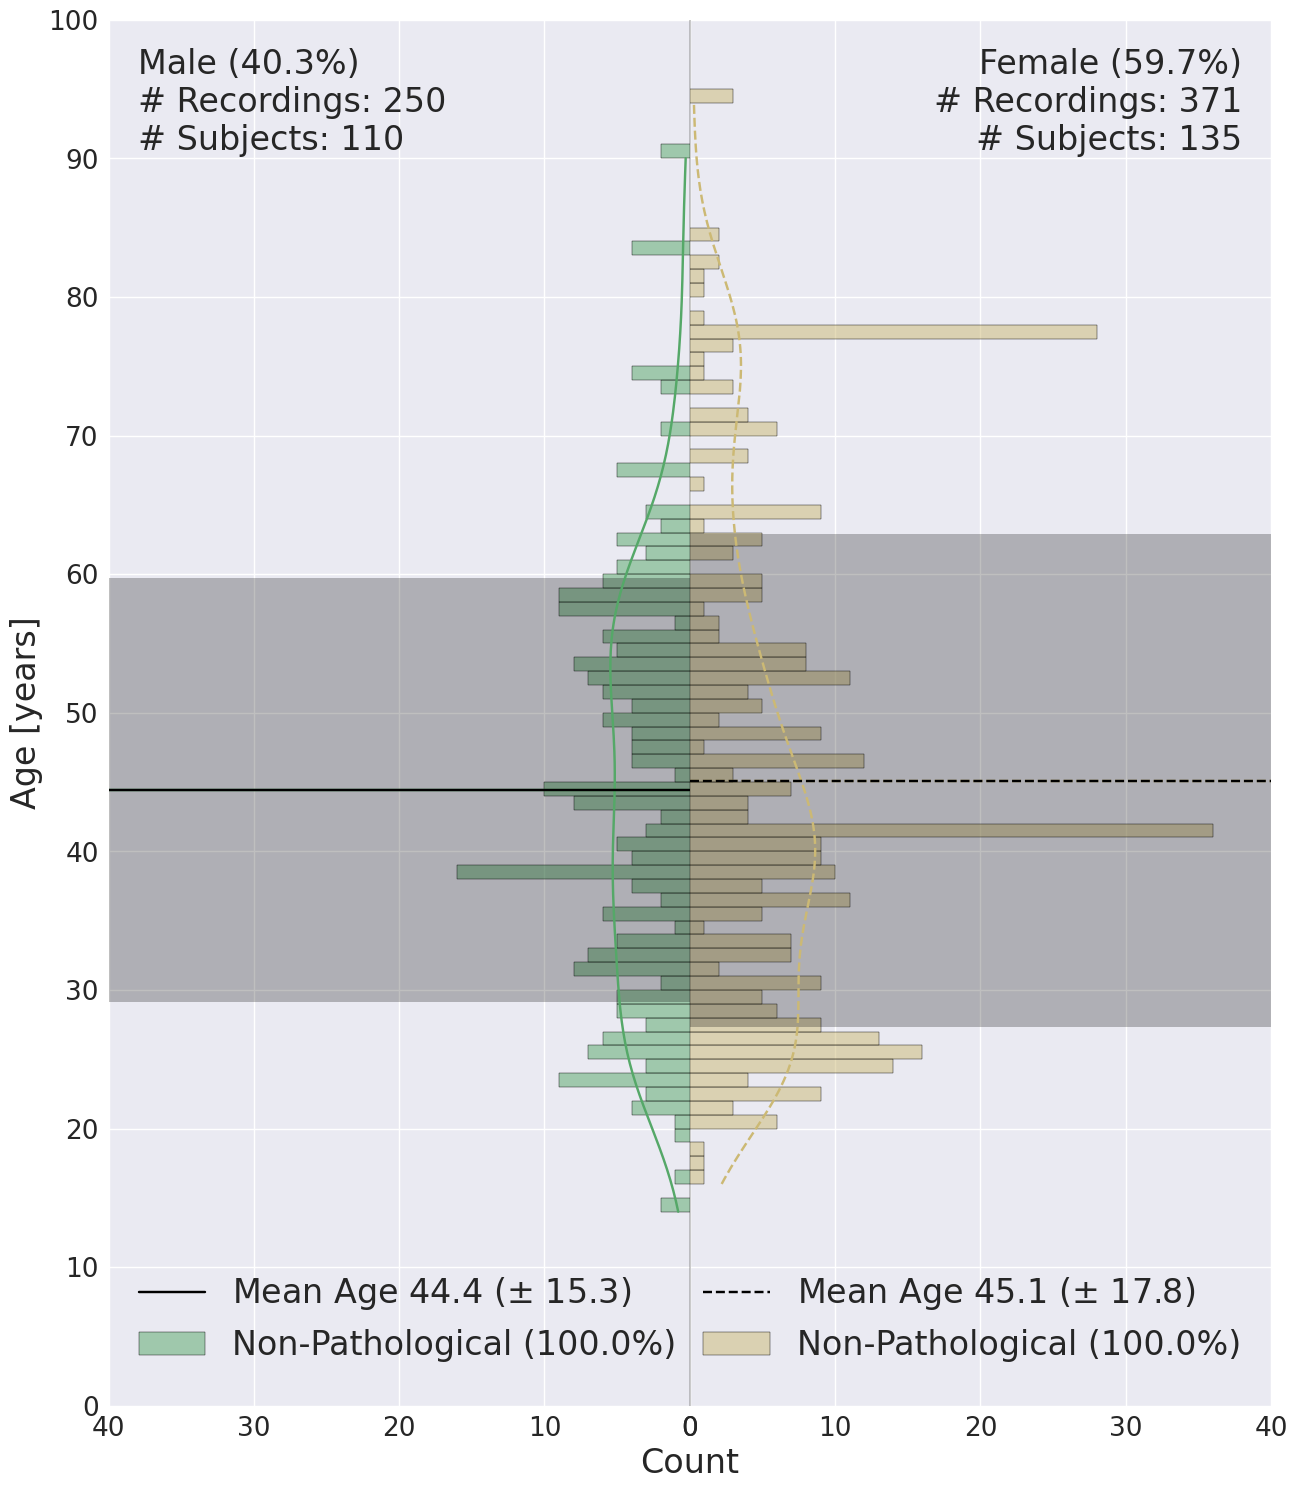

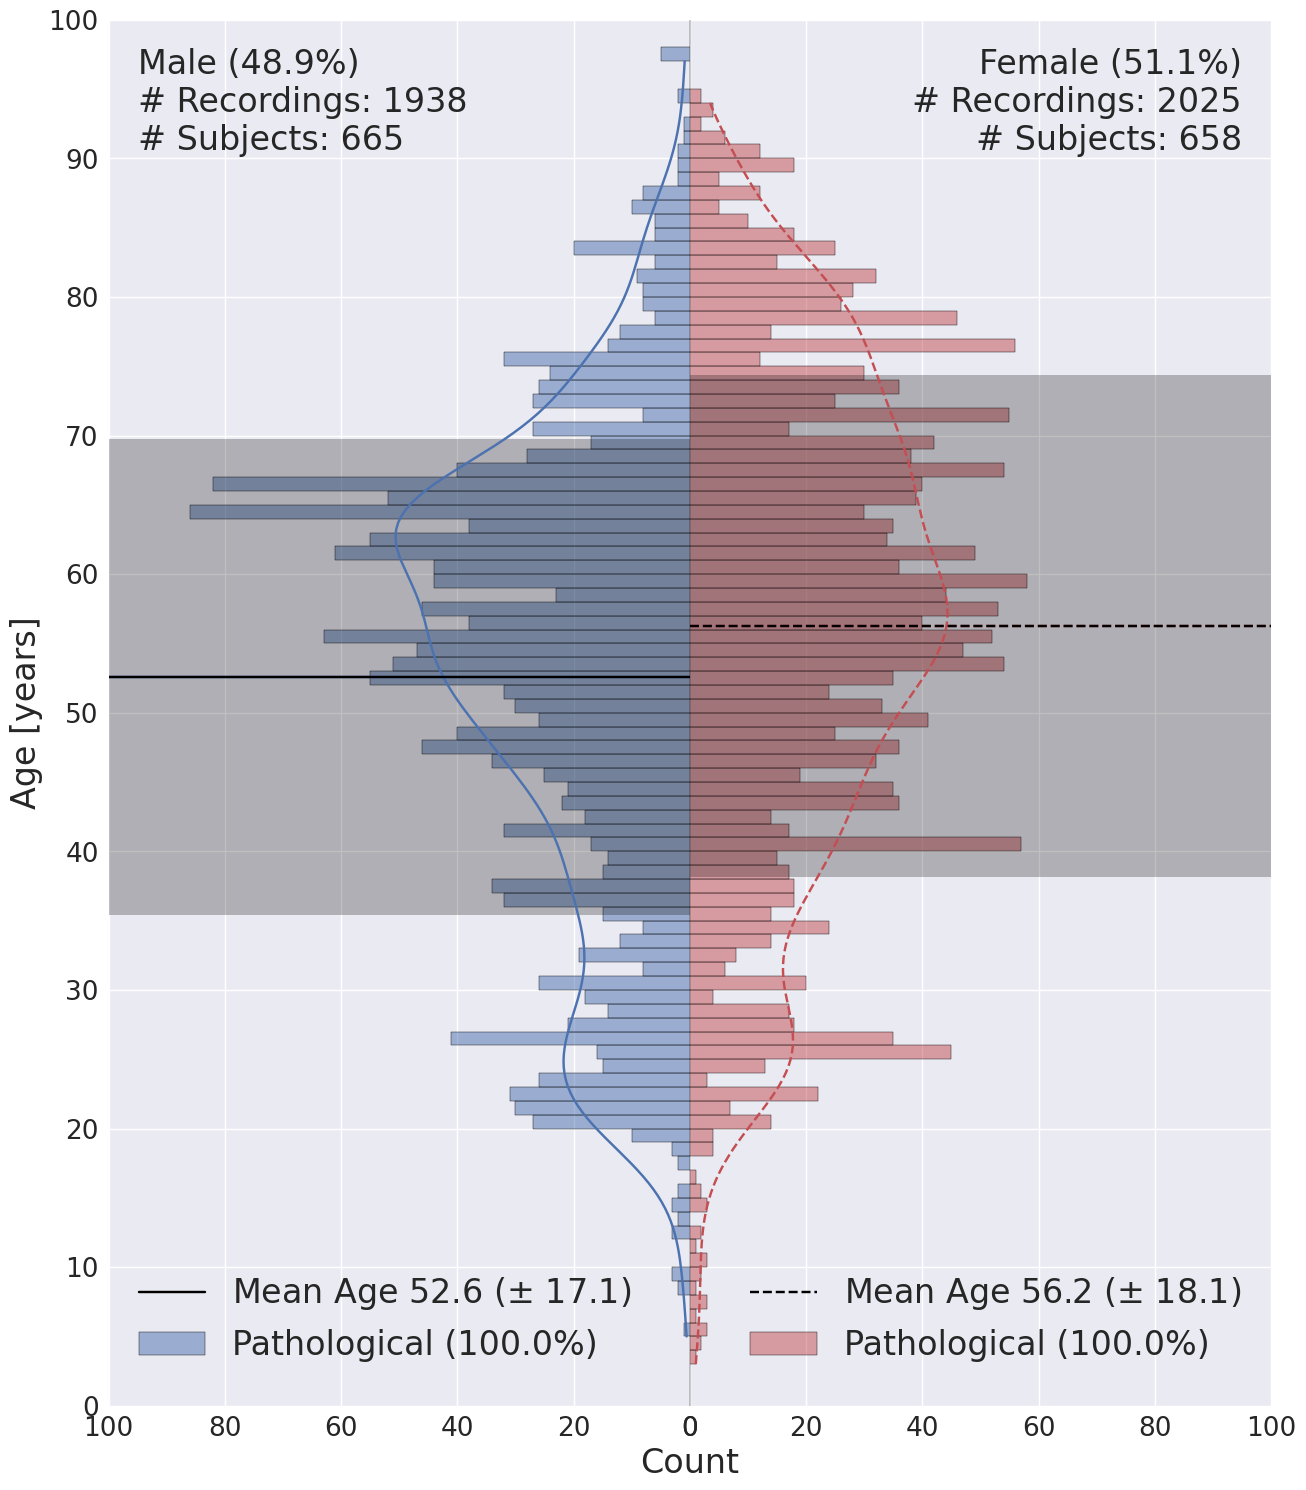

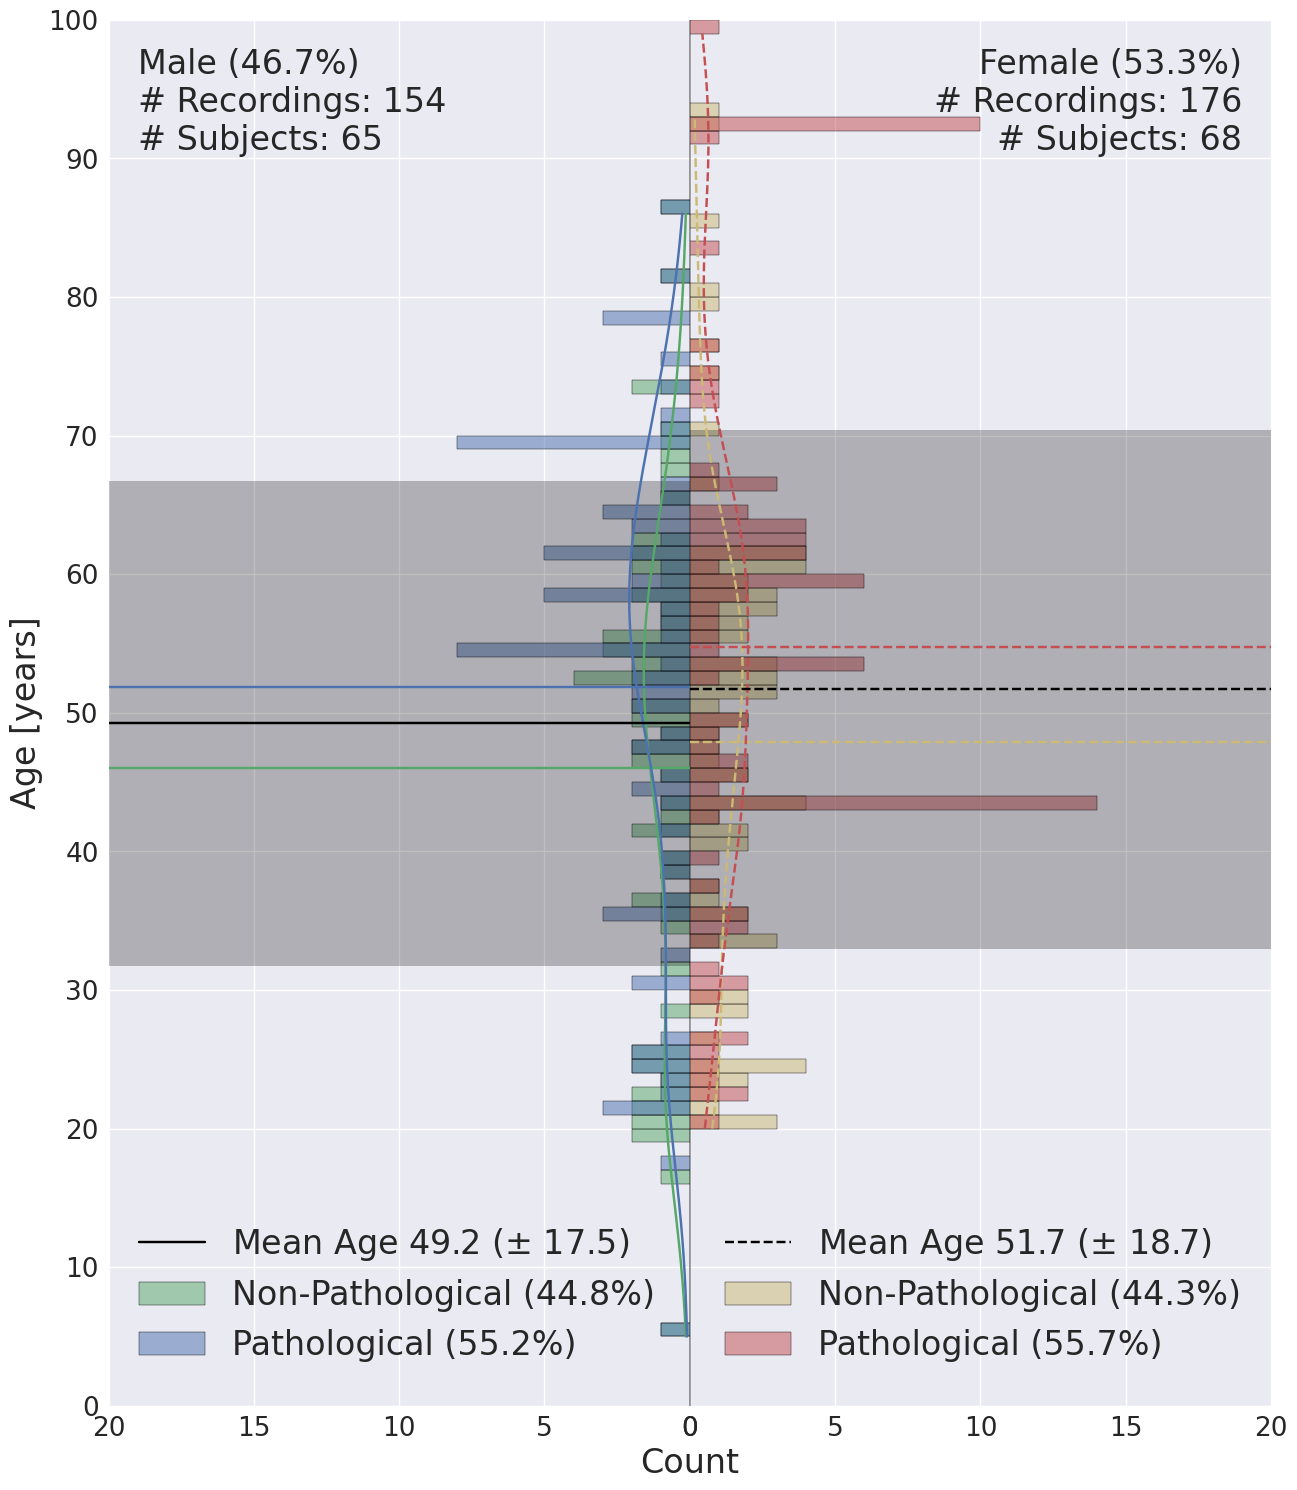

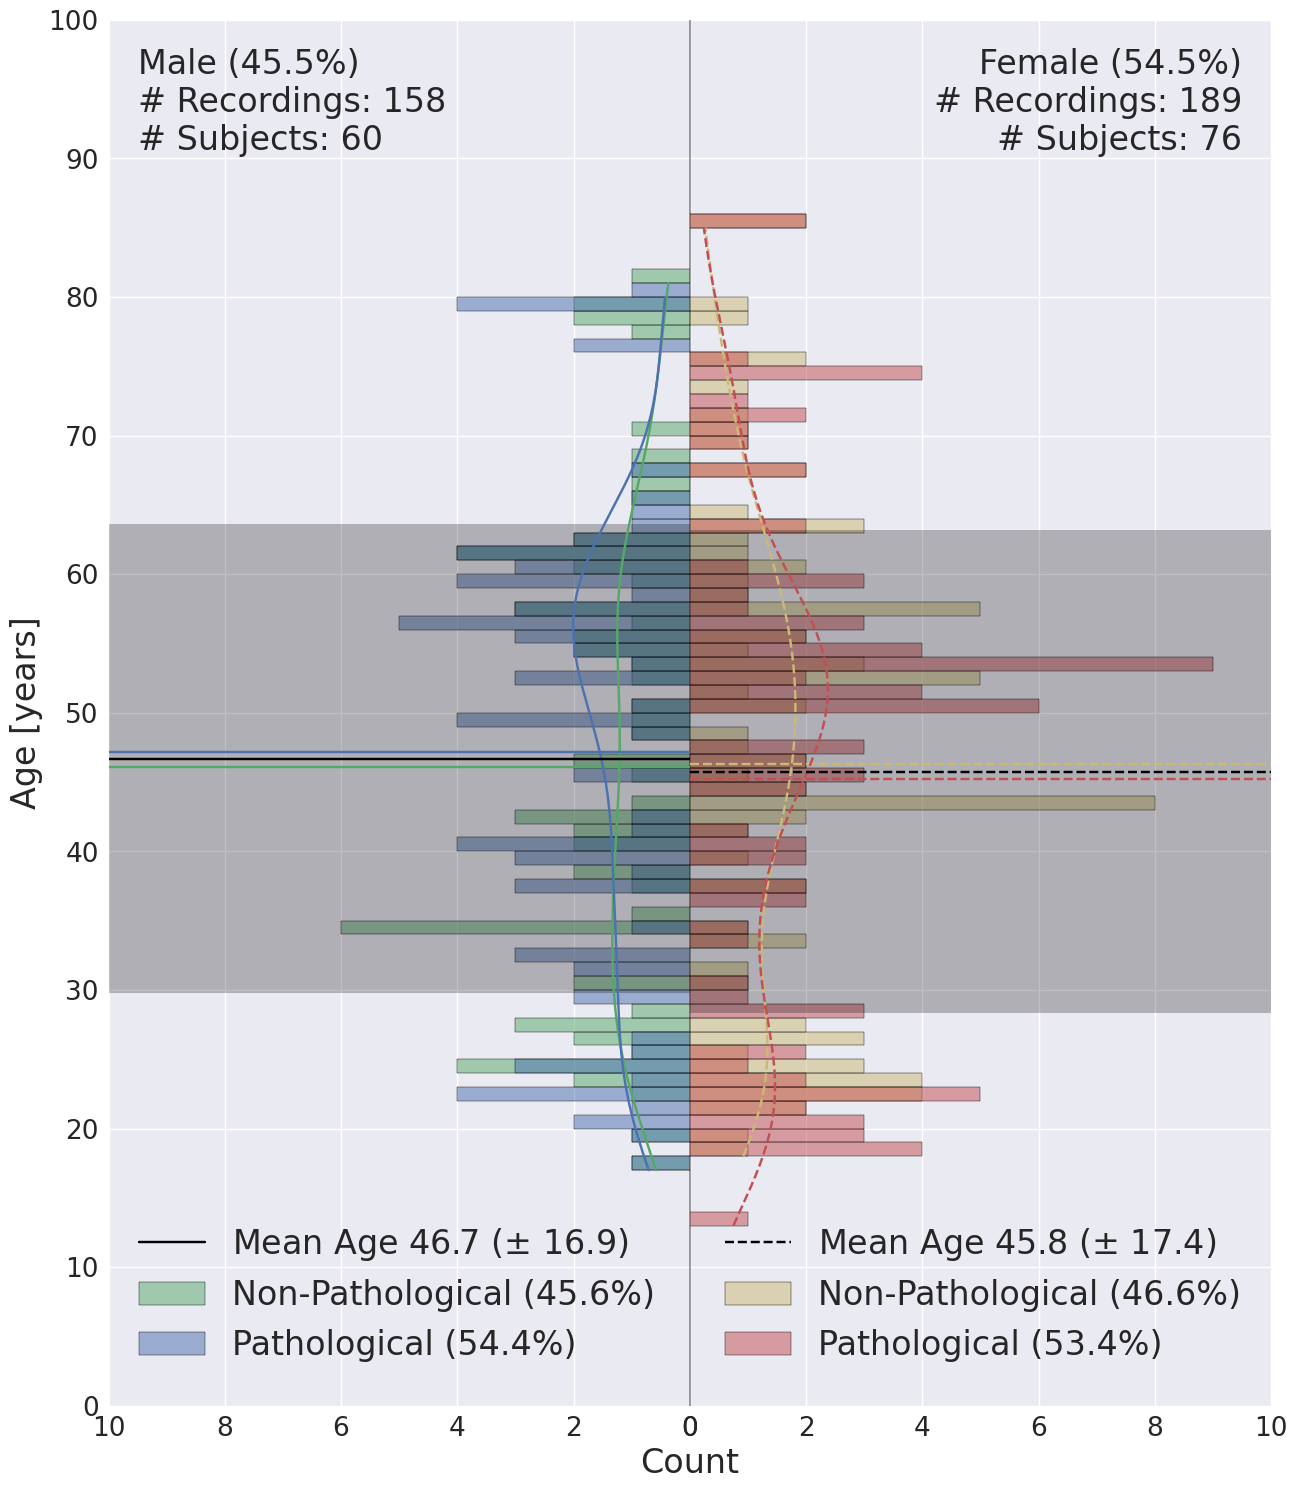

In [73]:
for ds_name in ['lnp', 'lp', 'lnpp', 'lpnp']:
    preds = read_result(exp_dir, f'{ds_name}')
    preds.replace({'M': 0, 'F': 1}, inplace=True)
    for seed, group in preds.groupby('seed'):
        break
    ax_arr = age_pyramid(group, f'eval_{ds_name}', ylim=ylims[ds_name], show_title=False)
    if save_figures:
        save_fig(ax_arr[0].get_figure(), '/home/jovyan/figures/', f'{ds_name}_age_pyramid')

In [73]:
def average_fe_runs(preds):
    preds = preds.reset_index().groupby(['dataset', 'subset', 'index'], as_index=False).mean(numeric_only=True)
    return preds

In [260]:
bin_size = 2
n_repetitions = 100
save_figures = False

In [261]:
min_mins = 15
clean_age = True
plot = True
subset_wise = True

In [262]:
assert min_mins == 15
#assert clean_age

In [727]:
exp_dir

'/home/jovyan/experiments/2023-02-15T18:43:26.819382'

In [774]:
for ds_name in ['lnp']:  # lnpp / lnp
    preds = read_result(exp_dir, f'{ds_name}')
    if ds_name in ['lnp', 'nlnp']:
        if ds_name == 'lnp':
            preds_p = read_result(exp_dir, 'lp')
        else:
            preds_p = read_result(exp_dir, 'nlp')
        preds = pd.concat([preds, preds_p])
        ds_name = 'lnp_lp'
    if ds_name in ['lnpp', 'nlnpp']:
        if ds_name == 'lnpp':
            preds_p = read_result(exp_dir, 'lpnp')
        else:
            preds_p = read_result(exp_dir, 'nlpnp')
        preds = pd.concat([preds, preds_p])
        ds_name = 'lnpp_lpnp'
    preds.replace({'M': 0, 'F': 1}, inplace=True)
    preds['pathological'] = preds.pathological == 1
    preds['gap'] = preds.y_pred - preds.y_true
    preds['dataset'] = ds_name
    print(preds.shape)
    preds, coeffs = add_deconfounded_predictions(preds, coeffs)
    print(preds.shape)
    1/0
    preds = average_fe_runs(preds)
    print(preds.shape)   
    subj_preds = preds.groupby(['dataset', 'subset', 'subject', 'pathological'], as_index=False).mean(numeric_only=True)
    print(subj_preds.shape)
    preds.y_pred = preds.y_pred_deconfounded_quadratic
    subj_preds.y_pred = subj_preds.y_pred_deconfounded_quadratic
    #1/0
    for d, g in subj_preds.groupby('subset'):
        for (n, m) in [('mae', mean_absolute_error), ('r2', r2_score)]:
            print(f'{d} {n} {m(g.y_pred, g.y_true):.2f}')
            print(f'{d} dummy {n} {m([g.y_true.mean()]*len(g.y_true), g.y_true):.2f}')

    # subset-wise vs. lnp and lp combined
    if ds_name == 'lnpp_lpnp':
        assert subset_wise
    if subset_wise:
        ite = subj_preds.groupby('subset')
    else:
        ite = [(ds_name, subj_preds)]
    for n, g in ite:
        print(n)
        if plot:
            ax = plot_heatmaps(g, bin_size)
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{n}_{min_mins}_{clean_age}_2dhistogram')

        if plot:
            ax = plot_permutation_test_and_age_gap_hist_with_thresh_and_permutation_test(
                g,
                t_low,
                t_high,
                bin_size,
                n_repetitions,
            )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{n}_{min_mins}_{clean_age}_age_gap_proxy')


/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230217/0/preds/train_end_lnp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230214/0/preds/train_end_lnp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230216/0/preds/train_end_lnp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230218/0/preds/train_end_lnp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230215/0/preds/train_end_lnp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230217/0/preds/train_end_lp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230214/0/preds/train_end_lp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230216/0/preds/train_end_lp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230218/0/preds/train_end_lp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230215/0/preds/train_end_lp_preds.csv
(22920, 26)
(22920, 29)


ZeroDivisionError: division by zero

In [775]:
preds.y_pred = preds.y_pred_deconfounded_quadratic

In [776]:
preds.groupby('subset').subject.nunique()

subset
lnp     245
lp     1321
Name: subject, dtype: int64

In [809]:
# schizo, depress, stroke
cond = 'stroke'

In [810]:
aas = []
for a, b in preds.groupby('subject'):
    if b.report.str.lower().str.contains(cond).any():
        aas.append(a)
        if not b.pathological.any():
            print(a)

1050
1387
1402
1743
2172
2256
3622
5624
5833
6681
7352
7642
10912
11381
12268


In [811]:
len(aas)

263

In [812]:
cond_preds = preds[preds.subject.isin(aas)]

In [813]:
cond_preds.groupby(['subset']).subject.nunique()

subset
lnp     15
lp     248
Name: subject, dtype: int64

In [814]:
cond_preds[cond_preds.subject==59].pathological

Series([], Name: pathological, dtype: bool)

In [815]:
print('\n'.join(cond_preds[cond_preds.subject==59].report.to_list()))

In [816]:
cond_preds = average_fe_runs(cond_preds)

In [817]:
cond_preds.groupby(['subset']).subject.nunique()

subset
lnp     15
lp     248
Name: subject, dtype: int64

p=1.00E-05
p=2.18E-02


(0.0, 20.0)

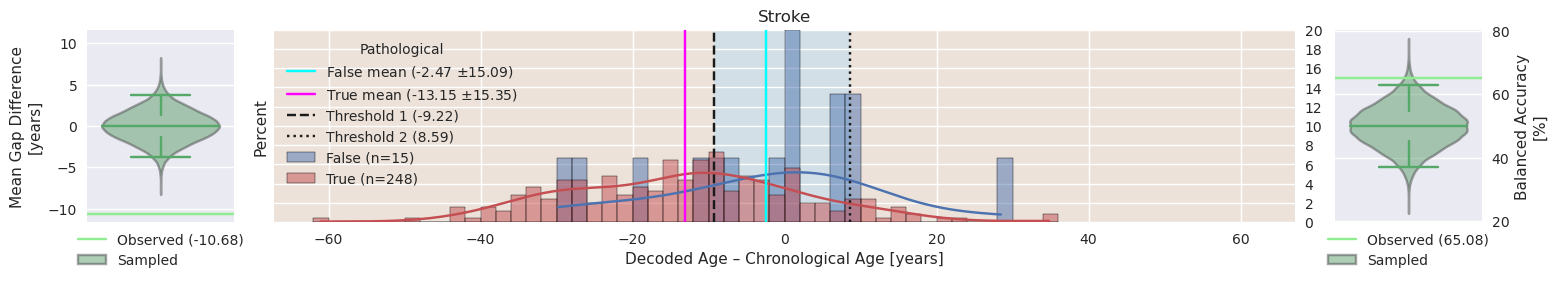

In [818]:
ax = plot_permutation_test_and_age_gap_hist_with_thresh_and_permutation_test(
    cond_preds, bin_width=2, 
    n_repetitions=100000,
    t_low=t_low, 
    t_high=t_high,
)

ax.set_title(cond_to_title[cond])
ax.set_ylim(0, 20)